In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings

warnings.filterwarnings("ignore")

# plt.style.use("icml.mplstyle")

In [2]:
EXPLANATORY_VARS = ["d", "K", "norm", "sigma", "n"]
TARGET_VARS = ["delta_mean", "delta_std"]

In [3]:
# Load the data
deltas = pd.read_csv("https://raw.githubusercontent.com/pchlenski/delta/main/deltas.csv", index_col=0).dropna()
deltas.head()

,d,K,norm,sigma,n,trial,delta_max,delta_mean,delta_abs_max,delta_abs_mean,delta_std,delta_abs_std
0,2.0,-4.0,0.0,0.0625,5.0,0.0,0.356044,-0.222216,2.000000,0.250318,0.438705,0.423300
1,2.0,-4.0,0.0,0.0625,5.0,1.0,0.147396,-0.155385,2.000000,0.171318,0.335217,0.327361
2,2.0,-4.0,0.0,0.0625,5.0,2.0,0.077345,-0.241864,2.000000,0.247315,0.490871,0.488148
3,2.0,-4.0,0.0,0.0625,5.0,3.0,0.401729,-0.198814,1.846844,0.227786,0.393135,0.377088
4,2.0,-4.0,0.0,0.0625,5.0,4.0,0.279749,-0.194695,1.410722,0.213009,0.373831,0.363707


In [30]:
# Split into K < 0, K = 0, and K > 0

H = deltas[deltas["K"] < 0]
HE = deltas[deltas["K"] <= 0]
E = deltas[deltas["K"] == 0]
SE = deltas[deltas["K"] >= 0]
S = deltas[deltas["K"] > 0]

ALL_GEOMS = [H, E, S]

# Individual variable effects

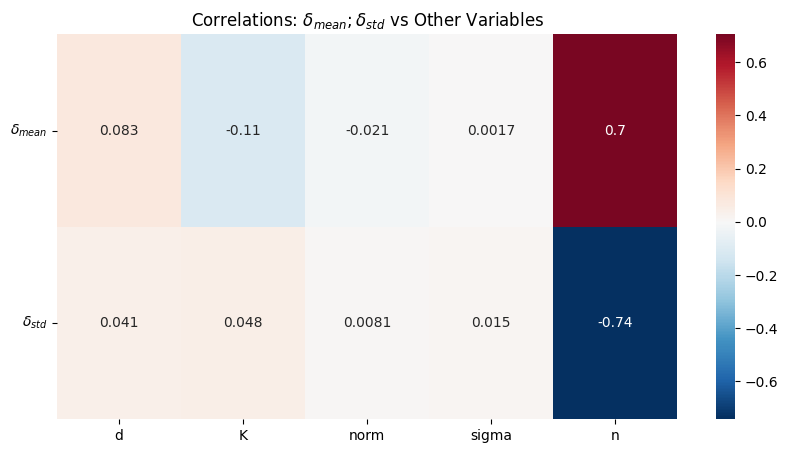

In [62]:
# Analyze relationships between delta_mean/delta_std and other variables

# Compute correlations
corr_matrix = deltas[EXPLANATORY_VARS + TARGET_VARS].corr()

# Visualize correlations
fig = plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix.loc[TARGET_VARS, EXPLANATORY_VARS], annot=True, cmap="RdBu_r", center=0)
plt.title("Correlations: $\\delta_{mean}; \\delta_{std}$ vs Other Variables")
plt.yticks([0.5, 1.5], [r"$\delta_{mean}$", r"$\delta_{std}$"], rotation=0)
plt.show()

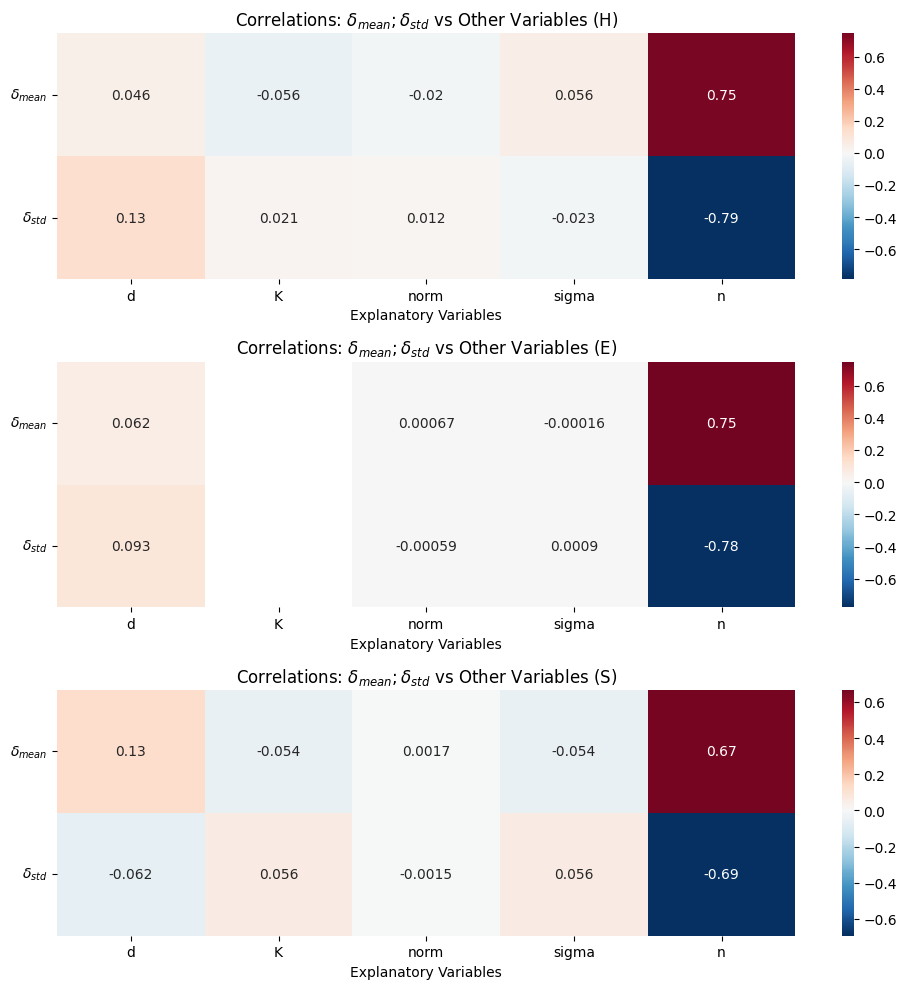

In [61]:
# Same thing but broken down by K
fig, axs = plt.subplots(len(ALL_GEOMS), 1, figsize=(10, 10))

for i, (geom, geom_name) in enumerate(zip(ALL_GEOMS, ["H", "E", "S"])):
    corr_matrix = geom[EXPLANATORY_VARS + TARGET_VARS].corr()
    sns.heatmap(corr_matrix.loc[TARGET_VARS, EXPLANATORY_VARS], annot=True, cmap="RdBu_r", center=0, ax=axs[i])
    axs[i].set_title(f"Correlations: $\\delta_{{mean}}; \\delta_{{std}}$ vs Other Variables ({geom_name})")
    axs[i].set_yticks([0.5, 1.5])
    axs[i].set_yticklabels([r"$\delta_{mean}$", r"$\delta_{std}$"], rotation=0)
    axs[i].set_xlabel("Explanatory Variables")
plt.tight_layout()
plt.show()

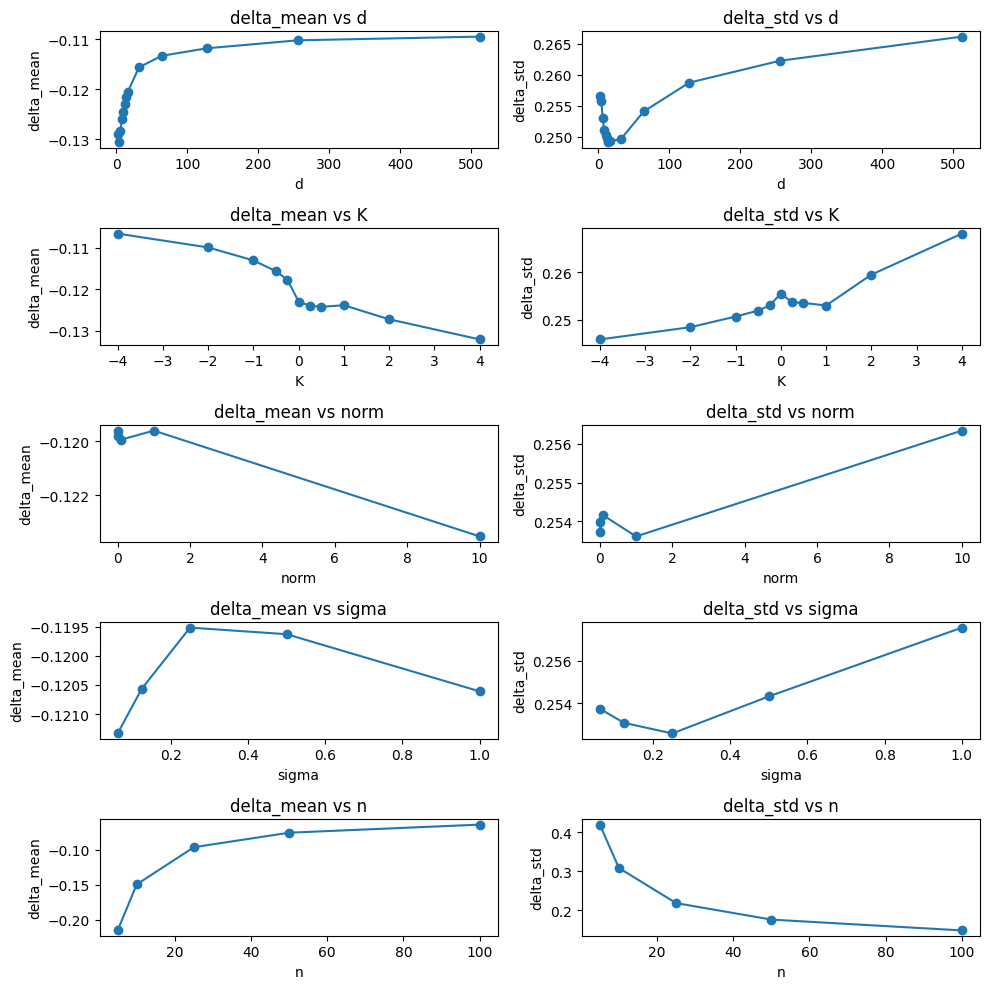

In [23]:
# Plot relationships between delta_mean/delta_std and other variables

fig, axs = plt.subplots(len(EXPLANATORY_VARS), len(TARGET_VARS), figsize=(10, 10))

for i, explanatory in enumerate(EXPLANATORY_VARS):
    data_grouped = deltas.groupby(explanatory).mean()
    for j, target in enumerate(TARGET_VARS):
        axs[i, j].plot(data_grouped.index, data_grouped[target], marker="o")
        axs[i, j].set_title(f"{target} vs {explanatory}")
        axs[i, j].set_xlabel(explanatory)
        axs[i, j].set_ylabel(target)

plt.tight_layout()

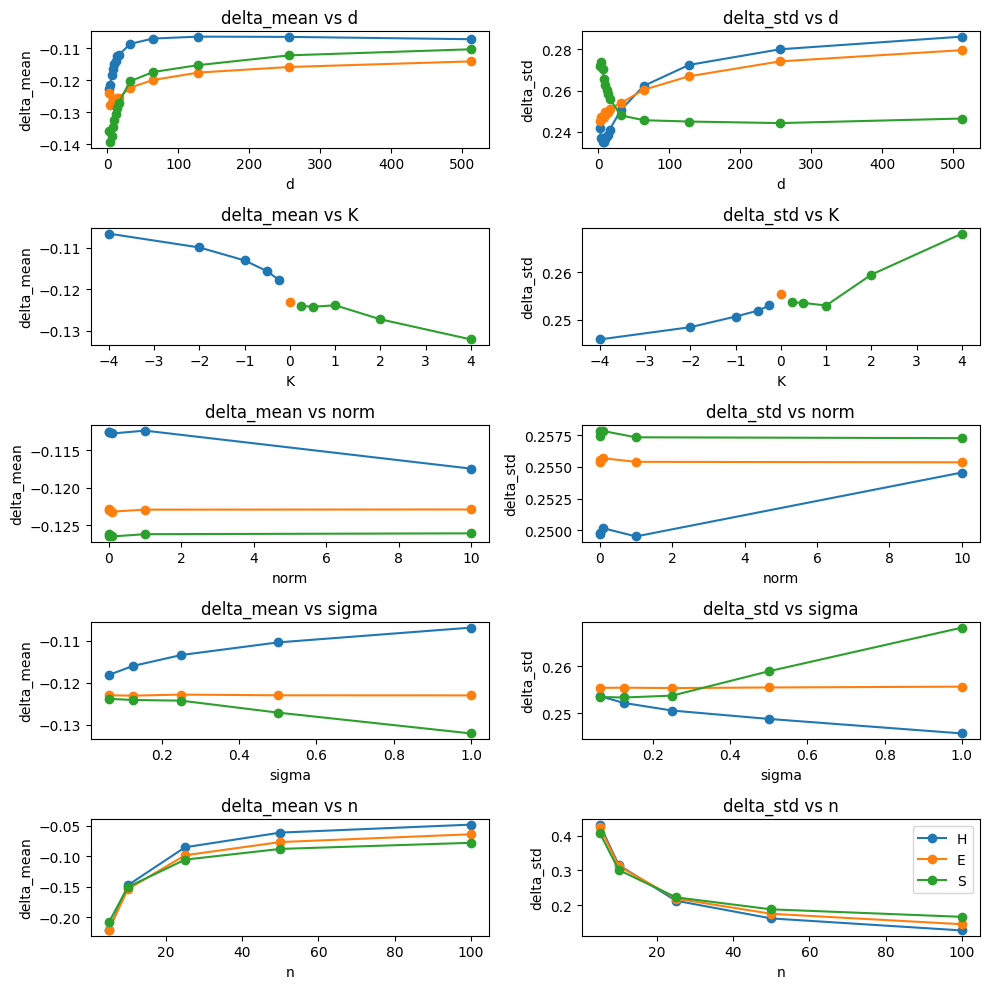

In [25]:
# Same thing but broken down by K
fig, axs = plt.subplots(len(EXPLANATORY_VARS), len(TARGET_VARS), figsize=(10, 10))

for i, explanatory in enumerate(EXPLANATORY_VARS):
    for j, target in enumerate(TARGET_VARS):
        for geom, geom_name in zip(ALL_GEOMS, ["H", "E", "S"]):
            data_grouped = geom.groupby(explanatory).mean()
            axs[i, j].plot(data_grouped.index, data_grouped[target], label=geom_name, marker="o")
        axs[i, j].set_title(f"{target} vs {explanatory}")
        axs[i, j].set_xlabel(explanatory)
        axs[i, j].set_ylabel(target)

axs[-1, -1].legend()
plt.tight_layout()

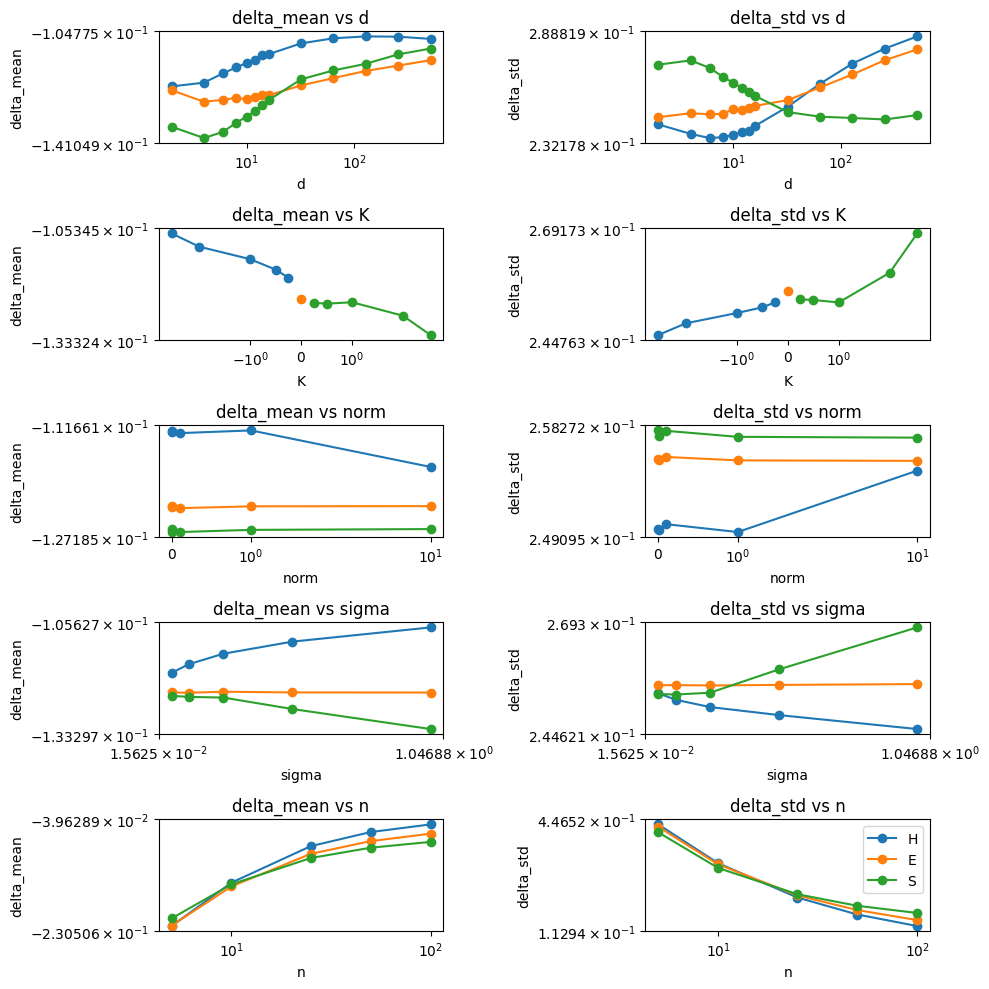

In [27]:
# Same thing but broken down by K
fig, axs = plt.subplots(len(EXPLANATORY_VARS), len(TARGET_VARS), figsize=(10, 10))

for i, explanatory in enumerate(EXPLANATORY_VARS):
    for j, target in enumerate(TARGET_VARS):
        for geom, geom_name in zip(ALL_GEOMS, ["H", "E", "S"]):
            data_grouped = geom.groupby(explanatory).mean()
            axs[i, j].plot(data_grouped.index, data_grouped[target], label=geom_name, marker="o")
        axs[i, j].set_title(f"{target} vs {explanatory}")
        axs[i, j].set_xlabel(explanatory)
        axs[i, j].set_ylabel(target)
        axs[i, j].set_yscale("symlog")
        axs[i, j].set_xscale("symlog")

axs[-1, -1].legend()
plt.tight_layout()

# Deriving scaling laws

## Kitchen sink model

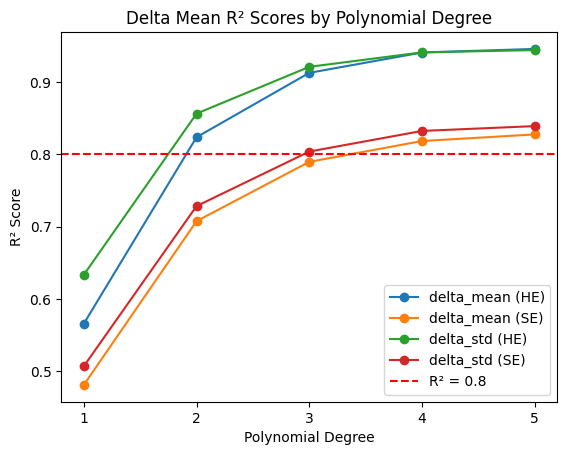

In [54]:
# How complex do our polynomials need to be to get R² > 0.8?

delta_mean_scores = {col: {geom: [] for geom in ["HE", "SE"]} for col in TARGET_VARS}
for deg in range(1, 6):
    poly = PolynomialFeatures(degree=deg, include_bias=False)

    for col in TARGET_VARS:
        for geom in ["HE", "SE"]:
            geom_data = HE if geom == "HE" else SE

            X_poly = poly.fit_transform(geom_data[EXPLANATORY_VARS])
            model = LinearRegression()
            model.fit(X_poly, geom_data[col])
            y_pred = model.predict(X_poly)
            r2 = r2_score(geom_data[col], y_pred)
            delta_mean_scores[col][geom].append(r2)

for col, scores in delta_mean_scores.items():
    plt.plot(range(1, 6), scores["HE"], label=f"{col} (HE)", marker="o")
    plt.plot(range(1, 6), scores["SE"], label=f"{col} (SE)", marker="o")
plt.axhline(0.8, linestyle="--", color="red", label="R² = 0.8")

plt.xlabel("Polynomial Degree")
plt.xticks(range(1, 6))
plt.ylabel("R² Score")
plt.title("Delta Mean R² Scores by Polynomial Degree")
plt.legend()
plt.show()

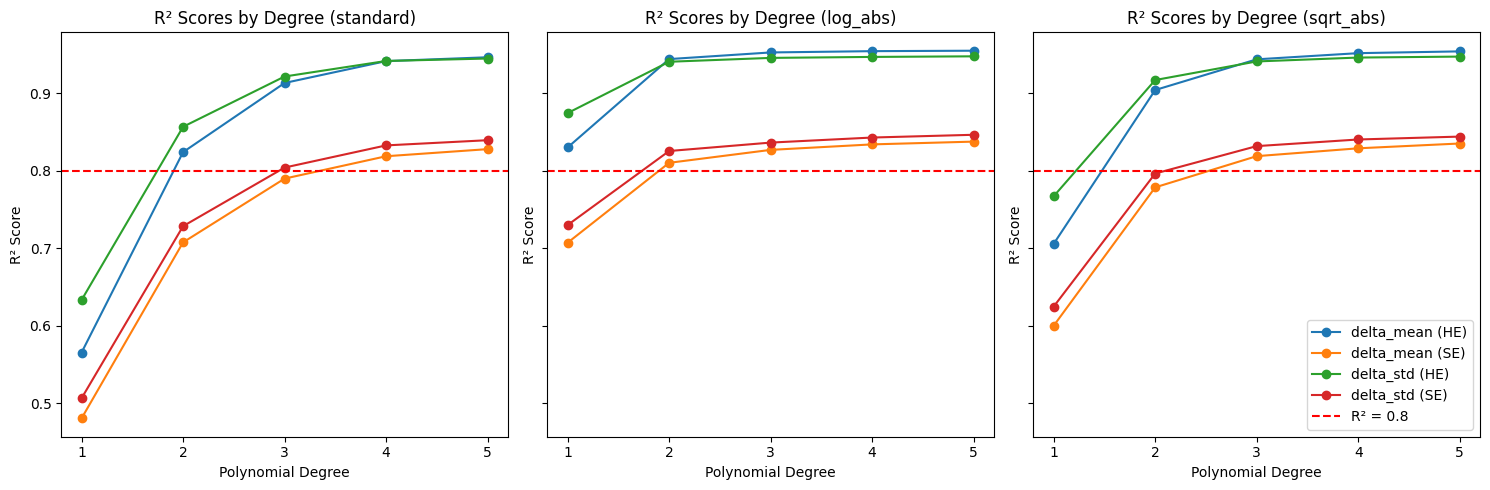

In [88]:
# Same thing, but now with some transformations applied as well

transformations = [
    {"name": "standard", "transform": lambda x: x},
    {"name": "log_abs", "transform": lambda x: np.log(np.abs(x) + 1e-8)},
    {"name": "sqrt_abs", "transform": lambda x: np.sqrt(np.abs(x))},
]

delta_scores = {t["name"]: {col: {geom: [] for geom in ["HE", "SE"]} for col in TARGET_VARS} for t in transformations}

for transform in transformations:
    transform_name = transform["name"]
    transform_func = transform["transform"]

    for deg in range(1, 6):
        poly = PolynomialFeatures(degree=deg, include_bias=False)

        for col in TARGET_VARS:
            for geom in ["HE", "SE"]:
                geom_data = HE if geom == "HE" else SE
                X_transformed = transform_func(geom_data[EXPLANATORY_VARS])

                X_poly = poly.fit_transform(X_transformed)
                model = LinearRegression()
                model.fit(X_poly, geom_data[col])
                y_pred = model.predict(X_poly)
                r2 = r2_score(geom_data[col], y_pred)
                delta_scores[transform_name][col][geom].append(r2)


fig, axes = plt.subplots(1, len(transformations), figsize=(15, 5), sharey=True)

for i, transform in enumerate(transformations):
    transform_name = transform["name"]
    ax = axes[i]

    for col, scores in delta_scores[transform_name].items():
        ax.plot(range(1, 6), scores["HE"], label=f"{col} (HE)", marker="o")
        ax.plot(range(1, 6), scores["SE"], label=f"{col} (SE)", marker="o")

    ax.axhline(0.8, linestyle="--", color="red", label="R² = 0.8")
    ax.set_xlabel("Polynomial Degree")
    ax.set_xticks(range(1, 6))
    ax.set_ylabel("R² Score")
    ax.set_title(f"R² Scores by Degree ({transform_name})")

ax.legend()
plt.tight_layout()
plt.show()

In [130]:
# Let's print out the equation we actually get here

DEGREE = 2
VAR_TO_EXPLAIN = "delta_std"


# Added X_poly and k to the function signature
def get_equation_str(model, poly_transformer, input_features, target_name, X_poly=None, k=None):
    poly_names = np.array(poly_transformer.get_feature_names_out(input_features))
    coeffs = model.coef_

    if k is not None:
        indices = np.argsort(np.abs(coeffs) * np.std(X_poly, axis=0))[::-1][:k]
        coeffs, poly_names = coeffs[indices], poly_names[indices]

    # This part is unchanged and now uses the filtered lists
    terms = " ".join(f"{'+' if coef >= 0 else '-'} {abs(coef):.4f} * {name}" for coef, name in zip(coeffs, poly_names))

    return f"{target_name} = {model.intercept_:.4f} {terms}"


poly = PolynomialFeatures(degree=DEGREE, include_bias=False)
X_log = transformations[1]["transform"](HE[EXPLANATORY_VARS])
X_poly = poly.fit_transform(X_log)
model = LinearRegression()
model.fit(X_poly, HE[VAR_TO_EXPLAIN])
y_pred = model.predict(X_poly)
r2 = r2_score(HE[VAR_TO_EXPLAIN], y_pred)
print(f"R² for {VAR_TO_EXPLAIN} with log transformation and degree {DEGREE}: {r2:.4f}")

equation_str = get_equation_str(model, poly, EXPLANATORY_VARS, VAR_TO_EXPLAIN)
# Break up equation string to lines < 120 characters
equation_str = "\n".join(" ".join(equation_str.split()[i : i + 20]) for i in range(0, len(equation_str.split()), 10))
print(f"Equation for {VAR_TO_EXPLAIN} with log transformation:\n{equation_str}")

R² for delta_std with log transformation and degree 2: 0.9405
Equation for delta_std with log transformation:
delta_std = 0.6686 + 0.0302 * d - 0.0016 * K + 0.0001 * norm + 0.0011 * sigma -
K + 0.0001 * norm + 0.0011 * sigma - 0.2293 * n + 0.0019 * d^2 + 0.0002 *
0.2293 * n + 0.0019 * d^2 + 0.0002 * d K - 0.0000 * d norm + 0.0015 *
d K - 0.0000 * d norm + 0.0015 * d sigma - 0.0099 * d n - 0.0001 *
d sigma - 0.0099 * d n - 0.0001 * K^2 + 0.0000 * K norm - 0.0001 * K
K^2 + 0.0000 * K norm - 0.0001 * K sigma - 0.0005 * K n + 0.0000 * norm^2
sigma - 0.0005 * K n + 0.0000 * norm^2 + 0.0000 * norm sigma + 0.0000 * norm n
+ 0.0000 * norm sigma + 0.0000 * norm n - 0.0003 * sigma^2 - 0.0028 * sigma n +
- 0.0003 * sigma^2 - 0.0028 * sigma n + 0.0251 * n^2
0.0251 * n^2


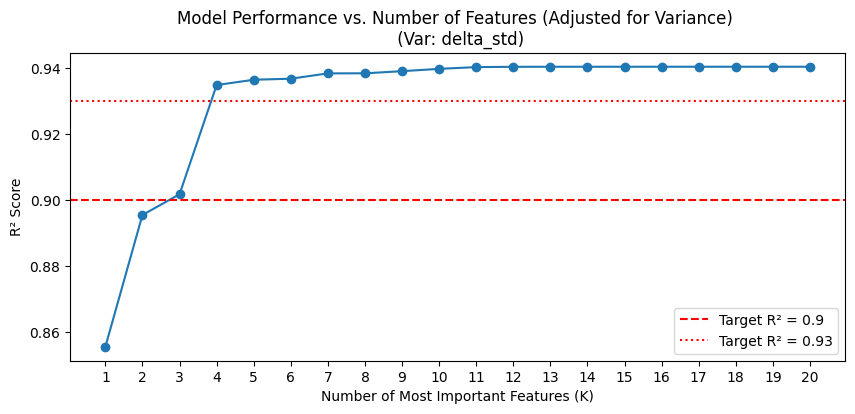

In [131]:
# 1. Calculate feature importance by scaling coefficients by the standard deviation
feature_importance = np.abs(model.coef_ * np.std(X_poly, axis=0))

# Get the indices of features sorted by this new importance metric
important_indices = np.argsort(feature_importance)[::-1]

# 2. Iteratively calculate R² for models with K features
r2_scores = []
k_features = range(1, len(model.coef_) + 1)

for k in k_features:
    # Select the top k most important feature indices
    top_k_indices = important_indices[:k]

    # Create a reduced dataset with only these features
    X_reduced = X_poly[:, top_k_indices]

    # Fit a new, simpler model on the reduced data
    model_k = LinearRegression()
    model_k.fit(X_reduced, HE[VAR_TO_EXPLAIN])

    # Calculate and store the R² score
    r2_scores.append(model_k.score(X_reduced, HE[VAR_TO_EXPLAIN]))

# 3. Plot the results
plt.figure(figsize=(10, 4))
plt.plot(k_features, r2_scores, marker="o", linestyle="-")
plt.xticks(k_features)

plt.xlabel("Number of Most Important Features (K)")
plt.ylabel("R² Score")
plt.title(f"Model Performance vs. Number of Features (Adjusted for Variance) \n (Var: {VAR_TO_EXPLAIN})")

# Add a reference line for your R² target
plt.axhline(0.9, color="red", linestyle="--", label="Target R² = 0.9")
plt.axhline(0.93, color="red", linestyle=":", label="Target R² = 0.93")
plt.legend()
plt.show()

In [133]:
# Let's print the top 4 equation here

TOPK = 6

# Create a reduced dataset with only these features
X_reduced = X_poly[:, important_indices[:TOPK]]

# Fit a new, simpler model on the reduced data
model_k = LinearRegression()
model_k.fit(X_reduced, HE[VAR_TO_EXPLAIN])

# Calculate and store the R² score
print(f"R² for model_k with {TOPK} features: {model_k.score(X_reduced, HE[VAR_TO_EXPLAIN])}")
equation_str = get_equation_str(model, poly, EXPLANATORY_VARS, VAR_TO_EXPLAIN, X_poly, k=TOPK)
print(f"Parsimonious equation for {VAR_TO_EXPLAIN} with log transformation:\n{equation_str}")

R² for model_k with 6 features: 0.9368281706029855
Parsimonious equation for delta_std with log transformation:
delta_std = 0.6686 - 0.2293 * n + 0.0251 * n^2 - 0.0099 * d n + 0.0302 * d + 0.0019 * d^2 - 0.0001 * K^2
